In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False)
    return combined_csv

In [3]:
# load data
exp_id = 1
path_to_results = Path('results_2025-03-13/')
path_to_results = Path('results/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)

exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])

print(exp_df['loc_algo'].unique())

['alp' 'mus' 'srp']


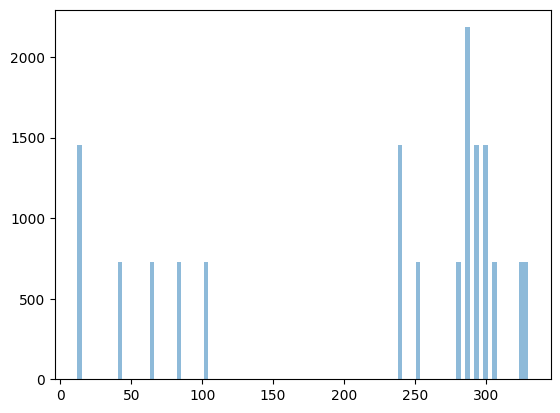

In [4]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

plt.hist(np.rad2deg(exp_df['doas_ref_az']), bins=100, alpha=0.5, label='doas_ref_az')
plt.show()

In [5]:
print('sv_model', exp_df['sv_model'].unique())
print('noise_type', exp_df['noise_type'].unique())
print('n_sources', exp_df['n_sources'].unique())
print('snr', exp_df['snr'].unique())
print('duration', exp_df['duration'].unique())
print('rt60', exp_df['rt60'].unique())
print('loc_method', exp_df['loc_method'].unique())

sv_model ['ref_8' 'alg_8' 'gp-steerer_8' 'gp-steerer_16' 'gp-steerer_32'
 'gp-steerer_64' 'gp-steerer_128']
noise_type ['awgn' 'alpha-1.2']
n_sources [1]
snr [-15 -12  -9  -6  -3   0   3   6   9  12  15  18  21]
duration [1.]
rt60 [0.273]
loc_method ['alpha-1.2_beta-1_eps-1E-3_iter-500' 'music_s-1' 'srp_phat'
 'alpha-X.X_beta-1_eps-1E-3_iter-500']


## which seed is better for GP?

In [6]:
exp_df[
    exp_df['sv_model'].isin(['gp-steerer_8', 'gp-steerer_16', 'gp-steerer_32', 'gp-steerer_64', 'gp-steerer_128'])
].pivot_table(
    index=['seed'], 
    columns=['nObs'],
    values='ang_error', 
    aggfunc=['mean', 'std']
).style.format("{:.2f}").background_gradient(cmap='viridis', axis=0)

In [7]:
best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666   
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

# METHOD vs SNR

Nice plots

In [8]:
noise_type = 'awgn'
# noise_type = 'alpha-1.2'

nice_plot_df = exp_df[
    (exp_df['noise_type'] == noise_type)
    & (exp_df['snr'] >= -20)
    & (exp_df['sv_model'].isin(['ref', 'alg', 'gp-steerer_32']))
    & (exp_df['loc_method'].isin([
        'srp_phat', 'music_s-1', 
        'alpha-1.2_beta-1_eps-1E-3_iter-500',
        'alpha-X.X_beta-1_eps-1E-3_iter-500']))
    & (exp_df['seed'] == best_seed)
    & (exp_df['rt60'] > -1)
    & (exp_df['duration'] == 1.)
]

# rename loc_methods and sv_models
nice_plot_df.loc[nice_plot_df['loc_method'] == 'srp_phat', 'loc_method'] = 'SRP-PHAT'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'music_s-1', 'loc_method'] = 'MUSIC-1'
# nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'SHAMaNS-1.2'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-X.X_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'SHAMaNS'

nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'sv_model'] = 'Ref.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'sv_model'] = 'Alg.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'gp-steerer_32', 'sv_model'] = 'NS-32'


print(nice_plot_df['loc_method'].unique())
print(nice_plot_df['sv_model'].unique())

algo_order = ['SRP-PHAT', 'MUSIC-1', 'SHAMaNS']
# algo_order = ['SRP-PHAT', 'MUSIC-1', 'SHAMaNS-1.2', 'SHAMaNS-est']
n_algos = len(algo_order)


['alpha-1.2_beta-1_eps-1E-3_iter-500' 'MUSIC-1' 'SRP-PHAT' 'SHAMaNS']
['Ref.' 'Alg.' 'NS-32']


In [9]:
perf = pd.pivot_table(nice_plot_df, values='ang_error', index=['snr'], columns=['loc_method', 'rt60', 'sv_model'], aggfunc=np.mean)
perf

/tmp/ipykernel_580561/4131289036.py:1: FutureWarning: The provided callable <function mean at 0x7f87c411daf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  perf = pd.pivot_table(nice_plot_df, values='ang_error', index=['snr'], columns=['loc_method', 'rt60', 'sv_model'], aggfunc=np.mean)


loc_method MUSIC-1            SHAMaNS             SRP-PHAT             \
rt60         0.273              0.273                0.273              
sv_model      Alg. NS-32 Ref.    Alg. NS-32  Ref.     Alg. NS-32 Ref.   
snr                                                                     
-15           10.8   3.9  8.1    70.2  58.2  45.9     11.4   4.5  3.3   
-12            9.9   3.0  2.7    70.2  45.9  18.0      6.9   3.0  2.4   
-9             9.6   2.4  1.2    71.1  40.5  15.3      4.5   2.1  0.9   
-6             9.0   2.4  1.5    70.5  24.0  10.8      3.9   1.8  0.3   
-3             9.0   2.4  1.8    72.0  10.2  10.2      3.6   1.2  0.3   
 0             9.3   2.4  1.5    61.8   9.9  10.2      4.2   1.2  0.3   
 3             9.0   2.4  1.2    57.0   9.3   2.4      5.1   1.2  0.3   
 6             9.0   2.4  1.2    45.6   8.7   1.8      5.4   1.2  0.3   
 9             9.0   2.4  1.2    36.6   1.5   1.5      5.4   1.2  0.3   
 12            9.0   2.1  1.2    39.3   0.9   0.9      5.4   1.2  0.3   
 15            9.0   2.1  0.9    36.6   1.5   0.6      5.7   1.2  0.3   
 18            9.0   2.1  0.9    42.6   1.2   0.6      5.7   0.9  0.6   
 21            9.0   2.1  0.9    44.4   0.9   0.6      5.7   0.9  0.6   

loc_method alpha-1.2_beta-1_eps-1E-3_iter-500              
rt60                                    0.273              
sv_model                                 Alg. NS-32  Ref.  
snr                                                        
-15                                      72.6  59.1  40.5  
-12                                      70.5  49.2  30.3  
-9                                       71.4  43.8  11.1  
-6                                       69.9  32.1  10.2  
-3                                       62.4   8.4   9.9  
 0                                       61.2   9.9   2.4  
 3                                       51.9   8.7   1.8  
 6                                       44.7   1.5   1.5  
 9                                       42.3   1.5   0.9  
 12                                      39.6   1.2   0.9  
 15                                      39.3   1.2   0.6  
 18                                      39.6   0.9   0.6  
 21                                      40.8   0.9   0.6

In [10]:
pd.pivot_table(nice_plot_df[nice_plot_df['snr'] > 0], 
               values='ang_error', 
               index=['loc_method'], 
               columns=['sv_model'], 
               aggfunc=[np.mean, np.std])

/tmp/ipykernel_580561/1128385715.py:1: FutureWarning: The provided callable <function mean at 0x7f87c411daf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.pivot_table(nice_plot_df[nice_plot_df['snr'] > 0],
/tmp/ipykernel_580561/1128385715.py:1: FutureWarning: The provided callable <function std at 0x7f87c411dc10> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  pd.pivot_table(nice_plot_df[nice_plot_df['snr'] > 0],


mean                            std  \
sv_model                                 Alg.     NS-32      Ref.       Alg.   
loc_method                                                                     
MUSIC-1                              9.000000  2.228571  1.071429   8.621539   
SHAMaNS                             43.157143  3.428571  1.200000  44.899291   
SRP-PHAT                             5.485714  1.114286  0.385714   7.496268   
alpha-1.2_beta-1_eps-1E-3_iter-500  42.600000  2.271429  0.985714  42.841317   

                                                         
sv_model                                NS-32      Ref.  
loc_method                                               
MUSIC-1                              2.909530  2.306210  
SHAMaNS                             15.786864  2.513847  
SRP-PHAT                             2.341634  1.476851  
alpha-1.2_beta-1_eps-1E-3_iter-500  11.344725  2.452383

/tmp/ipykernel_580561/2542717118.py:21: FutureWarning: The provided callable <function mean at 0x7f87c411daf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  perf = pd.pivot_table(


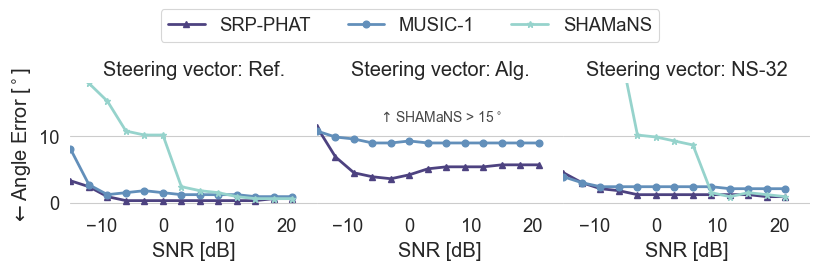

In [27]:
sns.set(style='whitegrid', context='paper', font_scale=1.5,
        rc={
            # 'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.size': 16,
            # 'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)

rt60s = nice_plot_df['rt60'].unique()
sv_models = nice_plot_df['sv_model'].unique()

fig, axarr = plt.subplots(1, len(sv_models),figsize=(8, 2), sharey=True, squeeze=False)

i= 0
rt60 = 0.273

perf = pd.pivot_table(
    nice_plot_df[nice_plot_df['rt60'] == rt60],
    values='ang_error', index=['snr'], columns=['loc_method', 'rt60', 'sv_model'], aggfunc=np.mean)

markers=['^','o','*','s','d','v'][:n_algos]

for j, sv_model in enumerate(sv_models):


    for alg,mkr in zip(algo_order, markers):
        axarr[i,j].plot(perf.index, perf[alg,rt60,sv_model], marker=mkr, clip_on=True, label=alg)

    # remove the x-grid
    axarr[i,j].xaxis.grid(False)
    
    axarr[i,j].set_title(f'Steering vector: {sv_model}')

    # nice legend box
    if j == 2:
        axarr[i,j].legend(algo_order, title='Loc. method', frameon=True, framealpha=0.6)
        handles, labels = axarr[i,j].get_legend_handles_labels()
        # print(handles, labels)
        axarr[i,j].legend_.remove()
    else:
        pass

    # set all the labels
    axarr[i,j].set_xlabel('SNR [dB]')
    if j == 0:
        axarr[i,j].set_ylabel(r"$\leftarrow$" + 'Angle Error [$^\circ$]')
    else:
        axarr[i,j].set_ylabel('')

    if j == 1:
        # get the color of the SHAMaNS line
        axarr[i,j].text(5, 13, r'$\uparrow$' + 'SHAMaNS > 15' + r"$^\circ$", color='k', fontsize=10, 
                        ha='center', va='center', alpha=0.8)
        
    axarr[i,j].set_xlim([-15,25])
    axarr[i,j].set_xticks([-10, 0, 10, 20])
    
    axarr[i,j].set_ylim([-0.5, 18])
    
    sns.despine(offset=10, trim=False, left=True, bottom=True, ax=axarr[i,j])

fig.legend(handles, labels, loc='upper center', ncol=n_algos, bbox_to_anchor=(0.5, 1.30))

# plt.suptitle(f'Experiment {exp_id} - noise {noise_type} - SNR Sweep - RT60 = {rt60} s', fontsize=14, y=1.30)

plt.tight_layout(pad=0)
plt.savefig('./eusipco2025_exp-1_snr-sweep_accuracy.pdf', bbox_inches='tight', dpi=300)